In [64]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bitcoin-historical-data/Bitcoin History.csv


# **1. Data Import**

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [66]:
df = pd.read_csv('/kaggle/input/bitcoin-historical-data/Bitcoin History.csv')

# 1-1. Data structure

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4955 entries, 0 to 4954
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      4955 non-null   object
 1   Price     4955 non-null   object
 2   Open      4955 non-null   object
 3   High      4955 non-null   object
 4   Low       4955 non-null   object
 5   Vol.      4955 non-null   object
 6   Change %  4955 non-null   object
dtypes: object(7)
memory usage: 271.1+ KB


In [68]:
df.shape

(4955, 7)

In [69]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Feb 09, 2024","47,545.4","45,293.3","47,710.2","45,254.2",86.85K,4.97%
1,"Feb 08, 2024","45,293.3","44,346.2","45,579.2","44,336.4",66.38K,2.15%
2,"Feb 07, 2024","44,339.8","43,088.4","44,367.9","42,783.5",48.57K,2.91%
3,"Feb 06, 2024","43,087.7","42,697.6","43,375.5","42,566.8",33.32K,0.91%
4,"Feb 05, 2024","42,697.2","42,581.4","43,532.2","42,272.5",39.26K,0.27%


# 1-2. Data Description

* **Date : Date of the recorded data.**
* **Price : Closing price of Bitcoin on the given date.**
* **Open : Opening price of Bitcoin on the given date.**
* **High : Highest price of Bitcoin on the given date.**
* **Low : Lowest price of Bitcoin on the given date.**
* **Vol. : Trading volume of Bitcoin on the given date.**
* **Change % : Percentage change in Bitcoin's price from the previous day**

# 1-3. Data precessing

In [70]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

In [ ]:
# Change the type
cols = ['Price', 'Open', 'High', 'Low']
for column in cols:
    df[column] = df[column].str.replace(',', '').astype(float)

In [72]:
# Vol. tranform 

def trans_vol(volume):
    if volume == '-':
        return 0  #for non-numeric values
    elif volume.endswith('K'):
        return float(volume.replace('K', '')) * 1e3
    elif volume.endswith('M'):
        return float(volume.replace('M', '')) * 1e6
    elif volume.endswith('B'):
        return float(volume.replace('B', '')) * 1e9
    else:
        return float(volume)
    
df['Vol.'] = df['Vol.'].apply(trans_vol)

In [73]:
df['Change %'] = df['Change %'].astype(str).str.replace('%', '').astype(float) 

# **2. Data Visualization**

* # Changes in Bitcoin Prices

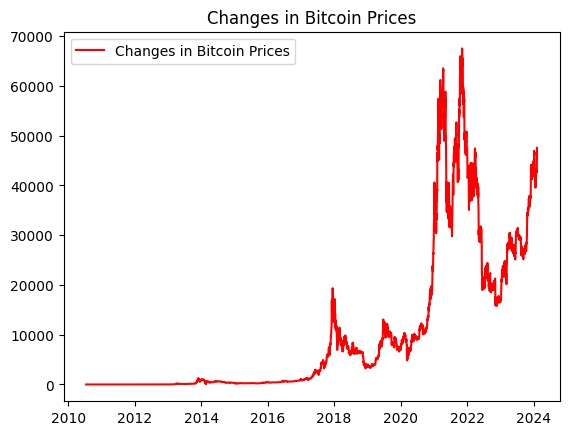

In [74]:
plt.plot(df['Date'], df['Price'], label = 'Changes in Bitcoin Prices',color = 'red')
plt.title('Changes in Bitcoin Prices')
plt.legend()
plt.show()

**Bitcoin prices have risen sharply in 2020 - 2022. Since then, it has fallen sharply and is rising again.**

* # Moving Average Variations (30 days) Graph

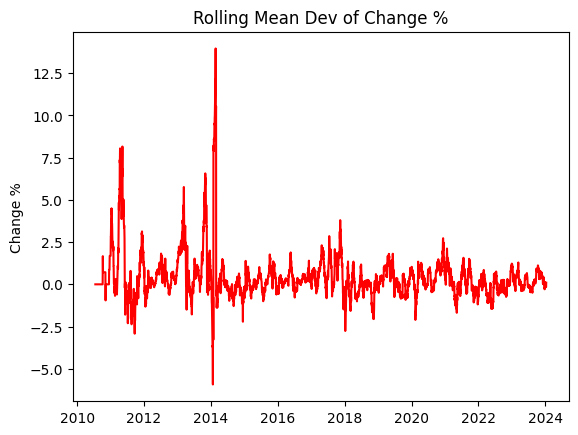

In [75]:
df2 = df.copy() 

if 'Date' in df2.columns:
    df2['Date'] = pd.to_datetime(df2['Date'])
    df2.set_index('Date', inplace=True)

df2['Rolling Mean Dev of Change %'] = df2['Change %'].rolling(window=30).mean()

plt.plot(df2['Rolling Mean Dev of Change %'], label='30-Day Rolling Mean Dev of Change %',color = 'red')
plt.title('Rolling Mean Dev of Change %')
plt.ylabel('Change %')
plt.show() 

* # Moving Std Dev Variations (30 days) Graph

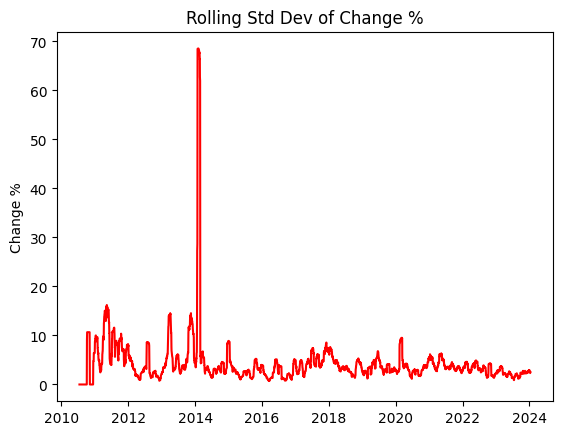

In [76]:
if 'Date' in df2.columns:
    df2['Date'] = pd.to_datetime(df2['Date'])
    df2.set_index('Date', inplace=True)

df2['Rolling Std Dev of Change %'] = df2['Change %'].rolling(window=30).std()

plt.plot(df2['Rolling Std Dev of Change %'], label='30-Day Rolling Std Dev of Change %',color = 'red')
plt.title('Rolling Std Dev of Change %')
plt.ylabel('Change %')
plt.show() 

**In the moving standard deviation and moving average graph, the variability in 2014 is the greatest.**

* # Scatter plot of Open, High, and Low vs Price
* # Scatter plot of Open, High, and Low vs Change %

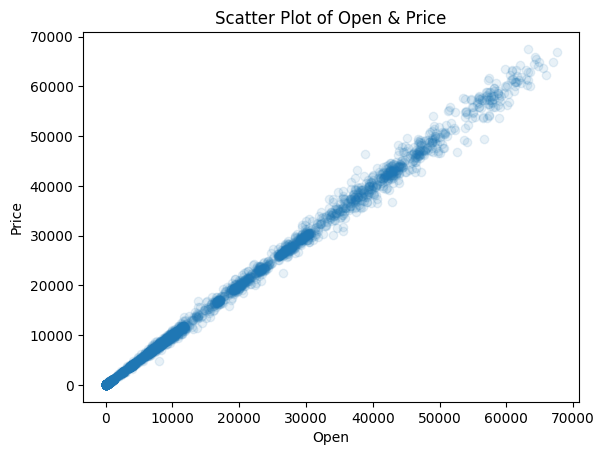

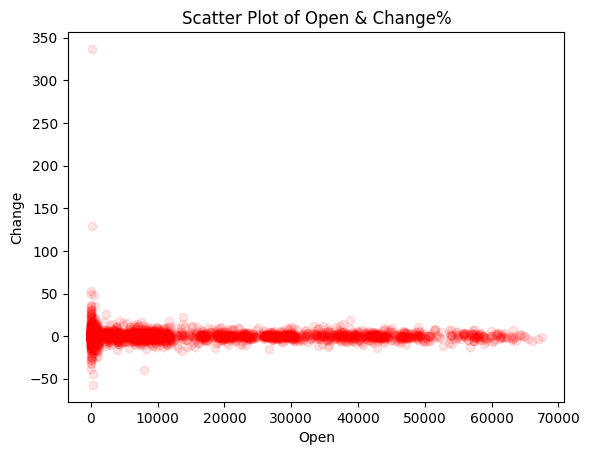

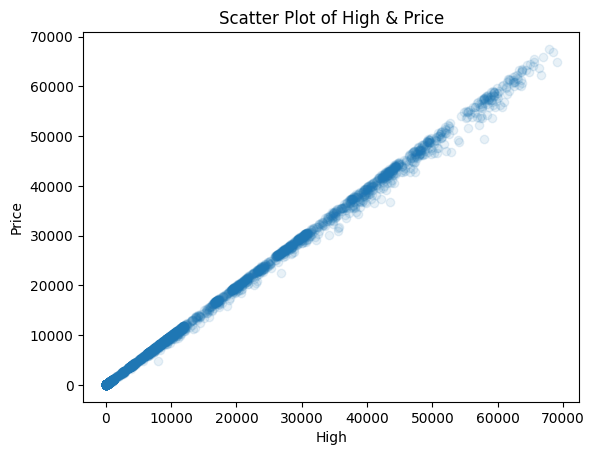

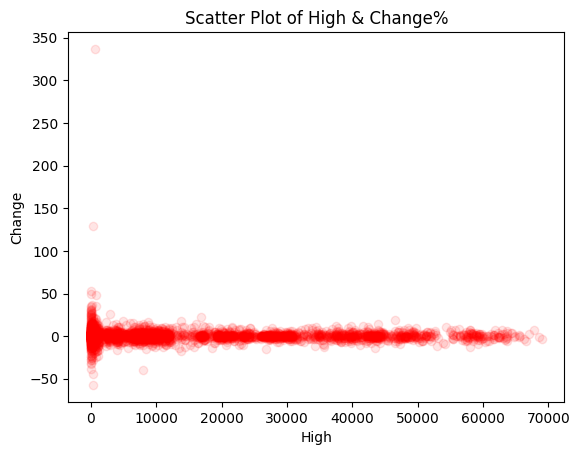

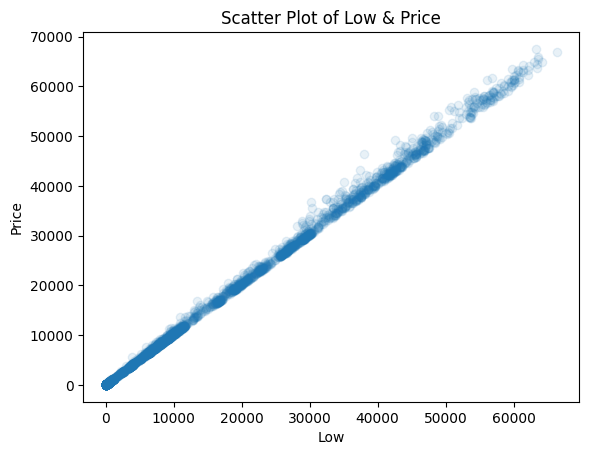

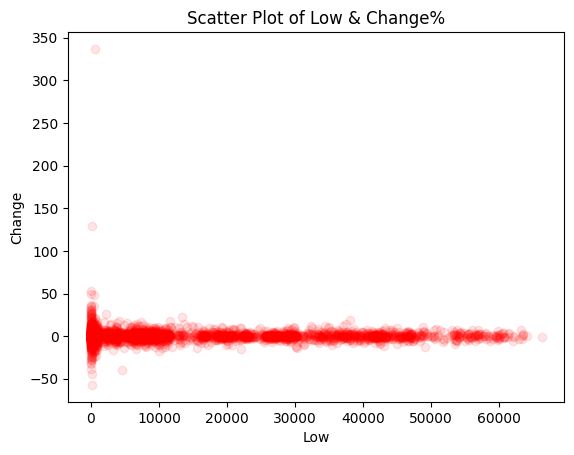

In [77]:
cols = ['Open', 'High', 'Low']

for i in cols:
    plt.scatter(df[i],df['Price'],alpha=0.1)
    plt.title(f'Scatter Plot of {i} & Price')
    plt.ylabel('Price')
    plt.xlabel(f'{i}')
    plt.show()
    
    plt.scatter(df[i],df['Change %'],alpha=0.1, color = 'red')
    plt.title(f'Scatter Plot of {i} & Change%')
    plt.ylabel('Change')
    plt.xlabel(f'{i}')
    plt.show()

**Bitcoin's volatility became smaller as the price increased.**

# 3. Modeling

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [79]:
X = df[['Open', 'High', 'Low', 'Vol.', 'Change %']]
Y = df['Price']

In [80]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

# 3-1. LinearRegression

In [81]:
md_lr = LinearRegression()

In [82]:
md_lr.fit(X_train,Y_train)

LinearRegression()

In [83]:
pred = md_lr.predict(X_test)

In [105]:
print(f'MAE : {mean_absolute_error(Y_test,pred)}')

MAE : 126.80872297313293


In [103]:
print(f'MSE : {mean_squared_error(Y_test,pred)}')

MSE : 88701.58930661228


In [104]:
print(f'RMSE : {np.sqrt(mean_squared_error(Y_test,pred))}')

RMSE : 297.82812040942724


In [107]:
print(f'r2_score : {r2_score(Y_test,pred)}')

r2_score : 0.999648472707976


* # MAE : 126.80872297313293
* # MSE : 88701.58930661228
* # RMSE : 297.82812040942724
* # R2_score : 0.999648472707976

# 3-2 RandomForestRegressor

In [86]:
md_rf = RandomForestRegressor(random_state=42)

In [87]:
md_rf.fit(X_train,Y_train)

RandomForestRegressor(random_state=42)

In [88]:
pred2 = md_rf.predict(X_test)

In [97]:
print(f'MAE : {mean_absolute_error(Y_test,pred2)}')

MAE : 106.70888597376356


In [101]:
print(f'MSE : {mean_squared_error(Y_test,pred2)}')

MSE : 71694.24875759838


In [102]:
print(f'RMSE : {np.sqrt(mean_squared_error(Y_test,pred2))}')

RMSE : 267.75781736038704


In [106]:
# coefficient of determination
print(f'r2_score : {r2_score(Y_test,pred2)}')

r2_score : 0.9997158733533811


* # MAE : 106.70888597376356
* # MSE : 71694.24875759838
* # RMSE : 267.75781736038704
* # R2_score : 0.9997158733533811

# **4.Evaluation**

# The smaller the MAE and MSE, the better the model, 
# So Random Frost regression is a better model.